In [1]:
from Annau2023.models import generator, critic
from Annau2023.SRModel import SRModelData, SuperResolver
from Annau2023.RAPSD import compute_rapsd
from Annau2023.progress_bar import progress_bar

import torch
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    'mathtext.default': 'regular',
    'text.latex.preamble': r'\usepackage{mathrsfs}',
    'pdf.fonttype': 42
})

In [2]:
lr_era_path  = "/workspace/Annau2023/data/idealized_data/era/"
lr_nfs_path  = "/workspace/Annau2023/data/nfs_pfs/"
lr_wrf_path  = "/workspace/Annau2023/data/idealized_data/wrf/"

model_list = [
    SRModelData(region="west", sr_model_name="NFS", generator_param_dim=(16, 128, 7, 2), exp_id="db9f0fae83c949eaad5d1176a43dae47", data_path=lr_nfs_path),
    SRModelData(region="west", sr_model_name="wrf_cov", generator_param_dim=(16, 128, 2, 2), exp_id="14b60d24b1634096b01734e9544ce08f", data_path=lr_wrf_path),
    SRModelData(region="west", sr_model_name="era_cov", generator_param_dim=(16, 128, 2, 2), exp_id="e047612597704ab38f2cc9c9aa4ec95f", data_path=lr_era_path),

    SRModelData(region="southeast", sr_model_name="NFS", generator_param_dim=(16, 128, 7, 2), exp_id="feda42500d2b45549be96f1bf62b0b03", data_path=lr_nfs_path),
    SRModelData(region="southeast", sr_model_name="wrf_cov", generator_param_dim=(16, 128, 2, 2), exp_id="6169bc060dc9465493fd3acab7477c45", data_path=lr_wrf_path),
    SRModelData(region="southeast", sr_model_name="era_cov", generator_param_dim=(16, 128, 2, 2), exp_id="663f3525ea1f4b258b822d5968e27ad0", data_path=lr_era_path),
    
    SRModelData(region="central", sr_model_name="NFS", generator_param_dim=(16, 128, 7, 2), exp_id="0c5ee480663f4f9eb7200f8879aa1244", data_path=lr_nfs_path),
    SRModelData(region="central", sr_model_name="wrf_cov", generator_param_dim=(16, 128, 2, 2), exp_id="ecb730e5079244c88a2843ef159a4c53", data_path=lr_wrf_path),
    SRModelData(region="central", sr_model_name="era_cov", generator_param_dim=(16, 128, 2, 2), exp_id="77230ef31f7e4c738ece08a41d7c3543", data_path=lr_era_path),
]

In [3]:
rapsd = {"southeast":{}, "central":{}, "west":{}}
ground_truth = {"southeast":{}, "central":{}, "west":{}}
for idx, model in enumerate(model_list):
    progress_bar(idx, len(model_list))

    lr, hr = model.load_test()
    generator = model.load_generator()
    sr = SuperResolver(region=model.region, lr=lr.float(), hr=hr.float(), G=generator, batch_size=1024)

    x = sr.super_resolve()
    y = sr.ground_truth()

    rapsd[model.region][model.sr_model_name] = compute_rapsd(x)
    rapsd[model.region]["WRF"]  = compute_rapsd(y)


In [4]:
k = rapsd["southeast"]["wrf_cov"]["k"]

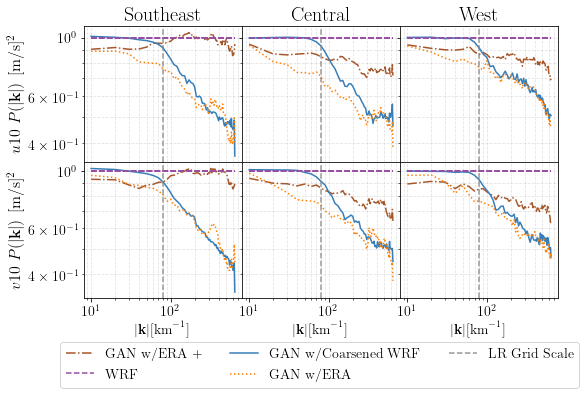

In [7]:
markermap = {
    "wrf_cov": "-",
    "era_cov": ":",
    "NFS": "-.",
    "WRF": "--"
}

colormap = {
    "wrf_cov": '#377eb8',
    "era_cov": '#ff7f00',
    "NFS": '#a65628',
    "WRF": '#984ea3'
}

titlemap = {
    "wrf_cov": "GAN w/Coarsened WRF",
    "era_cov": "GAN w/ERA",
    "NFS": "GAN w/ERA +",
    "WRF": "WRF"
}

var_ref = {"u10": 0, "v10": 0}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8.5, 5), sharey='row', sharex='col')
for j, region in enumerate(rapsd):
    for sr_model in rapsd[region]:
        rapsd[region][sr_model].pop("k") if "k" in rapsd[region][sr_model] else None
        for i, var in enumerate(var_ref):
            axes[i, j].loglog(
                10*k,
                rapsd[region][sr_model][var]/rapsd[region]["WRF"][var],
                label=titlemap[sr_model],
                color=colormap[sr_model],
                linestyle = markermap[sr_model]
            )

            axes[i, j].loglog(
                10*k,
                rapsd[region]["WRF"][var]/rapsd[region]["WRF"][var],
                # label="ground_truth",
                color=colormap["WRF"],
                linestyle = markermap["WRF"]
            )

            axes[i, 0].set_ylabel(fr"${var}$ "+r"$P(|\mathbf{k}|)$"+r" [m/s]$^2$", fontsize=16)
    axes[-1, j].set_xlabel(r"$|\mathbf{k}| [\textnormal{km}^{-1}]$")
    axes[0, j].set_title(region.capitalize(), fontsize=20)

for ax in axes.flat:
    ax.set_aspect("auto")
    ax.grid(linestyle="--", alpha=0.3, which="both", color='0.65')
    ax.grid(True)
    ax.yaxis.grid(True)
    ynew = 80
    ax.axvline(ynew, linestyle="--", color="grey", alpha=0.8, label="LR Grid Scale")

axes[1, 1].legend(ncol=3, frameon=True, bbox_to_anchor=(0.49023, -0.49), loc='center', fontsize=14)   

fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig(
    "/workspace/paper/pdfs/fig9.pdf",
    bbox_inches='tight',
    format='pdf',
    dpi=350
)
